In [17]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nbp174/training_data_no_bp.npz


In [18]:
%%writefile tranlstm.py
import torch
import math
from torch.nn.modules import Transformer, TransformerEncoder, TransformerEncoderLayer, LayerNorm
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from typing import Dict, Tuple, Optional, List
import copy

# ---------- 在这里直接定义掩码生成函数（替代原外部导入）----------
def generate_square_subsequent_mask(sz: int):
    """Generates an upper-triangular matrix of -inf, with zeros on diag."""
    return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)

# ---------- 以下是你的原始 tranlstm.py 全部内容（只删除了那行 import）----------
class MyTransformer(torch.nn.Module):
    def __init__(
            self,
            device,
            number_time_series: int,
            seq_length: int = 48,
            output_seq_len: int = None,
            d_model: int = 128,
            n_heads: int = 8,
            dropout=0.1,
            forward_dim=2048,
            sigmoid=False):
        super().__init__()
        if output_seq_len is None:
            output_seq_len = seq_length
        self.out_seq_len = output_seq_len
        self.mask = generate_square_subsequent_mask(seq_length).to(device)
        self.dense_shape = torch.nn.Linear(number_time_series, d_model)
        self.dense_t = torch.nn.Linear(1, d_model)
        self.pe = SimplePositionalEncoding(d_model)
        self.transformer = Transformer(
            d_model,
            nhead=n_heads,
            num_encoder_layers=1,
            num_decoder_layers=1,
            device=device,
            activation=torch.nn.functional.selu,
            dropout=0)
        self.final_layer = nn.Linear(d_model, 1)
        self.permute_layer = nn.Linear(seq_length, 1)
        self.sequence_size = seq_length
        self.tgt_mask = generate_square_subsequent_mask(seq_length).to(device)

    def forward(self, x, t, tgt_mask=None):
        x = self.encode_sequence(x, src_mask=self.mask)
        x = self.decode_seq(x, t, tgt_mask)
        x = x.permute(2, 1, 0)
        x = self.permute_layer(x)
        return x

    def basic_feature(self, x: torch.Tensor):
        x = self.dense_shape(x)
        x = self.pe(x)
        x = x.permute(1, 0, 2)
        return x

    def basic_t(self, x: torch.Tensor):
        x = self.dense_t(x)
        x = self.pe(x)
        x = x.permute(1, 0, 2)
        return x

    def encode_sequence(self, x, src_mask=None):
        x = self.basic_feature(x)
        x = self.transformer.encoder(src=x, mask=src_mask)
        return x

    def decode_seq(self, mem, t, tgt_mask=None, view_number=None) -> torch.Tensor:
        if view_number is None:
            view_number = self.out_seq_len
        if tgt_mask is None:
            tgt_mask = self.tgt_mask
        t = self.basic_t(t)
        x = self.transformer.decoder(t, mem, tgt_mask=tgt_mask)
        x = self.final_layer(x)
        return x

class GLU(nn.Module):
    def __init__(self, input_dim: int, output_dim: int):
        super(GLU, self).__init__()
        self.fc = nn.Linear(input_dim, output_dim*2)
    def forward(self, x):
        x = F.glu(self.fc(x))
        return x

class GRN(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, output_dim: int,
                 dropout: Optional[float] = 0.05,
                 context_dim: Optional[int] = None):
        super().__init__()
        self.layernorm = nn.LayerNorm(output_dim)
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        if context_dim is not None:
            self.context_fc = nn.Linear(context_dim, hidden_dim)
        self.skip = nn.Linear(input_dim, output_dim)
        self.forw = nn.Sequential(
            nn.ELU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Dropout(dropout),
            GLU(input_dim=output_dim, output_dim=output_dim))
    def forward(self, x, c: Optional[torch.Tensor] = None):
        res = self.skip(x)
        x = self.fc1(x)
        if c is not None:
            c = self.context_fc(c)
            x += c
        x = self.forw(x) + res
        x = self.layernorm(x)
        return x

class VariableSelectionNetwork(nn.Module):
    def __init__(self,
                 input_dim: int,
                 input_num: int,
                 hidden_dim: int,
                 dropout: float,
                 context_dim: Optional[int] = None):
        super(VariableSelectionNetwork, self).__init__()
        self.hidden_dim = hidden_dim
        self.input_dim = input_dim
        self.input_num = input_num
        self.dropout = dropout
        self.context_dim = context_dim
        self.flattened_grn = GRN(
            input_dim=self.input_num * self.input_dim,
            hidden_dim=self.hidden_dim,
            output_dim=self.input_num,
            dropout=self.dropout,
            context_dim=self.context_dim)
        self.softmax = nn.Softmax(dim=1)
        self.single_variable_grns = nn.ModuleList()
        for _ in range(self.input_num):
            self.single_variable_grns.append(
                GRN(input_dim=self.input_dim,
                    hidden_dim=self.hidden_dim,
                    output_dim=self.hidden_dim,
                    dropout=self.dropout,
                    context_dim=context_dim))
    def forward(self, flattened_embedding, context=None):
        x = flattened_embedding.reshape(flattened_embedding.shape[0], -1)
        sparse_weights = self.flattened_grn(x, context)
        sparse_weights = self.softmax(sparse_weights).unsqueeze(2)
        processed_inputs = []
        for i in range(self.input_num):
            processed_inputs.append(
                self.single_variable_grns[i](x[..., (i * self.input_dim): (i + 1) * self.input_dim], context))
        processed_inputs = torch.stack(processed_inputs, dim=-1)
        outputs = processed_inputs * sparse_weights.transpose(1, 2)
        return outputs, sparse_weights

class StaticCovariateEncoder(nn.Module):
    def __init__(self, f_dim, hidden_dim):
        super(StaticCovariateEncoder, self).__init__()
        self.f_dim = f_dim
        self.vsn = VariableSelectionNetwork(
            input_dim=hidden_dim,
            input_num=4,
            hidden_dim=hidden_dim,
            dropout=0.1,
            context_dim=hidden_dim,
        )
        self.grn = nn.ModuleList([GRN(
            input_dim=hidden_dim,
            hidden_dim=hidden_dim,
            output_dim=hidden_dim,) for _ in range(4)])
    def forward(self, x):
        variable_ctx, sparse_weights = self.vsn(x)
        variable_ctx = variable_ctx.sum(axis=-1)
        cs, ce, cc, ch = tuple(m(variable_ctx) for m in self.grn)
        return cs, ce, cc, ch

class RnnEecoder(nn.Module):
    def __init__(self, f, n):
        super().__init__()
        self.f = f
        self.n = n
        self.lstm = nn.LSTM(1, self.n, batch_first=True)
        self.gate = GLU(self.n, self.n)
        self.fc = nn.Linear(f, n)
        self.layernorm = nn.LayerNorm(n, eps=1e-5)
    def forward(self, x: torch.Tensor, c_h: torch.Tensor, c_c: torch.Tensor):
        res = x
        if self.f != self.n:
            res = self.fc(res)
        h0 = (c_h.unsqueeze(0), c_c.unsqueeze(0))
        x, (hn, cn) = self.lstm(x, hx=h0)
        x = self.layernorm(self.gate(x) + res)
        return x

class InterpretableMultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.n_head = config.n_head
        assert config.hidden_dim % config.n_head == 0
        self.i = 0
        self.d_head = config.hidden_dim // config.n_head
        self.qkv_linears = nn.Linear(config.hidden_dim, (2 * self.n_head + 1) * self.d_head, bias=True)
        self.out_proj = nn.Linear(self.d_head, config.hidden_dim, bias=True)
        self.attn_dropout = nn.Dropout(config.attn_dropout)
        self.out_dropout = nn.Dropout(config.dropout)
        self.scale = self.d_head**-0.5
        self.register_buffer("_mask", torch.triu(torch.full((config.example_length, config.example_length), float('-inf')), 1).unsqueeze(0))
    def forward(self, x: torch.Tensor, mask_future_timesteps: bool = True) -> Tuple[Tensor, Tensor]:
        bs, t, h_size = x.shape
        qkv = self.qkv_linears(x)
        q, k, v = qkv.split((self.n_head * self.d_head, self.n_head * self.d_head, self.d_head), dim=-1)
        q = q.view(bs, t, self.n_head, self.d_head)
        k = k.view(bs, t, self.n_head, self.d_head)
        v = v.view(bs, t, self.d_head)
        attn_score = torch.matmul(q.permute((0, 2, 1, 3)), k.permute((0, 2, 3, 1)))
        attn_score.mul_(self.scale)
        if mask_future_timesteps:
            attn_score = attn_score + self._mask
        attn_prob = F.softmax(attn_score, dim=3)
        attn_prob = self.attn_dropout(attn_prob)
        attn_vec = torch.matmul(attn_prob, v.unsqueeze(1))
        m_attn_vec = torch.mean(attn_vec, dim=1)
        out = self.out_proj(m_attn_vec)
        out = self.out_dropout(out)
        return out, attn_vec

class TemporalFusionDecoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, context_dim, output_dim, config):
        super().__init__()
        self.example_length = config.example_length
        self.enrichment_grn = GRN(
            input_dim=input_dim,
            hidden_dim=hidden_dim,
            output_dim=output_dim,
            dropout=0.05,
            context_dim=context_dim
        )
        self.attention = InterpretableMultiHeadAttention(config)
        self.att_gate = GLU(config.hidden_dim, config.hidden_dim)
        self.attention_ln = LayerNorm(config.hidden_dim, eps=1e-3)
        self.positionwise_grn = GRN(config.hidden_dim,
                                    config.hidden_dim,
                                    dropout=config.dropout,
                                    output_dim=config.hidden_dim)
        self.decoder_gate = GLU(config.hidden_dim, config.hidden_dim)
        self.decoder_ln = LayerNorm(config.hidden_dim, eps=1e-3)
    def forward(self, x, ce):
        res = x[:, -1, :]
        ce = ce.unsqueeze(1).repeat(1, self.example_length, 1)
        enriched = self.enrichment_grn(x, c=ce)
        x, _ = self.attention(enriched)
        x = x[:, -1, :]
        enriched = enriched[:, -1, :]
        x = self.att_gate(x)
        x = x + enriched
        x = self.attention_ln(x)
        x = self.positionwise_grn(x)
        x = self.decoder_gate(x)
        x = x + res
        x = self.decoder_ln(x)
        return x

class TemporalFusionTransformer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.static_encoder1 = VariableSelectionNetwork(
                input_dim=config.static_dim,
                input_num=config.static_num,
                hidden_dim=config.hidden_dim,
                dropout=0.1)
        self.static_encoder2 = StaticCovariateEncoder(config.hidden_dim, config.hidden_dim)
        self.varialbe_selection = VariableSelectionNetwork(
            input_dim=config.temporal_dim,
            input_num=config.example_length,
            hidden_dim=config.example_length,
            dropout=0.1,
            context_dim=config.hidden_dim,
        )
        self.rnn_encoder = RnnEecoder(1, config.hidden_dim)
        self.time_decoder = TemporalFusionDecoder(config.hidden_dim, config.hidden_dim, config.hidden_dim, config)
    def forward(self, x, b):
        b, _ = self.static_encoder1(b)
        cs, ce, ch, cc = self.static_encoder2(b)
        x, _ = self.varialbe_selection(x, cs)
        x = x.unsqueeze(-1)
        x = self.rnn_encoder(x, ch, cc)
        x = self.time_decoder(x, ce)
        return x

class LstmVsn(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.input_dim = 3
        self.memory_cell = 8
        self.body_dim = 4
        self.n = 16
        config.hidden_dim = self.input_dim*self.memory_cell
        self.lstm1 = nn.LSTM(1, 8, batch_first=True)
        self.lstm2 = nn.LSTM(1, 8, batch_first=True)
        self.lstm3 = nn.LSTM(1, 8, batch_first=True)
        self.fusion_lstm = nn.LSTM(24, 24, batch_first=True)
        self.static_encoder1 = VariableSelectionNetwork(
                input_dim=config.static_dim,
                input_num=config.static_num,
                hidden_dim=config.hidden_dim,
                dropout=0.1)
        self.static_encoder2 = StaticCovariateEncoder(config.hidden_dim, config.hidden_dim)
        self.time_decoder = TemporalFusionDecoder(
            input_dim=config.hidden_dim,
            hidden_dim=config.hidden_dim,
            context_dim=config.hidden_dim,
            output_dim=config.hidden_dim,
            config=config)
        self.fc1 = nn.Linear(8, 24)
        self.fc2 = nn.Linear(8, 24)
        self.fc3 = nn.Linear(8, 24)
        self.bottle_neck = nn.Sequential(
            nn.Linear(config.hidden_dim*4, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )
    def forward(self, x, b):
        b, _ = self.static_encoder1(b)
        cs, ce, ch, cc = self.static_encoder2(b)
        x1, (hn, cn) = self.lstm1(x[..., 0].unsqueeze(-1))
        x2, (hn, cn) = self.lstm2(x[..., 1].unsqueeze(-1))
        x3, (hn, cn) = self.lstm3(x[..., 2].unsqueeze(-1))
        x = torch.cat((x1, x2, x3), dim=-1)
        x, (hn, cn) = self.fusion_lstm(x)
        x = self.time_decoder(x, cs)
        x1 = self.fc1(x1[:, -1])
        x2 = self.fc2(x2[:, -1])
        x3 = self.fc3(x3[:, -1])
        x = torch.cat((x, x1, x2, x3), dim=-1)
        x = self.bottle_neck(x)
        return x

class LstmVsn2(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.input_dim = 3
        self.memory_cell = 8
        self.body_dim = 4
        self.n = 16
        self.lstm1 = nn.LSTM(1, self.memory_cell, batch_first=True)
        self.lstm2 = nn.LSTM(1, self.memory_cell, batch_first=True)
        self.lstm3 = nn.LSTM(1, self.memory_cell, batch_first=True)
        config.hidden_dim = self.input_dim*self.memory_cell
        self.static_encoder1 = VariableSelectionNetwork(
                input_dim=config.static_dim,
                input_num=config.static_num,
                hidden_dim=config.hidden_dim,
                dropout=0.1)
        self.static_encoder2 = StaticCovariateEncoder(config.hidden_dim, config.hidden_dim)
        self.time_decoder = TemporalFusionDecoder(config.hidden_dim, config.hidden_dim, config.hidden_dim, config)
        self.fc1 = nn.Linear(8, 1)
        self.fc2 = nn.Linear(8, 1)
        self.fc3 = nn.Linear(8, 1)
        self.skip_fc = nn.Linear(self.input_dim+1, 1)
    def forward(self, x, b):
        b, _ = self.static_encoder1(b)
        cs, ce, ch, cc = self.static_encoder2(b)
        x1, (hn, cn) = self.lstm1(x[..., 0].unsqueeze(-1))
        x2, (hn, cn) = self.lstm2(x[..., 1].unsqueeze(-1))
        x3, (hn, cn) = self.lstm3(x[..., 2].unsqueeze(-1))
        x = torch.cat((x1, x2, x3), dim=2)
        x = self.time_decoder(x, ce)
        x1 = self.fc1(x1[:, -1])
        x2 = self.fc2(x2[:, -1])
        x3 = self.fc3(x3[:, -1])
        x = torch.cat((x, x1, x2, x3), dim=1)
        x = self.skip_fc(x)
        return x

class SimplePositionalEncoding(torch.nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(SimplePositionalEncoding, self).__init__()
        self.dropout = torch.nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
        nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
    elif isinstance(m, nn.BatchNorm2d):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

Overwriting tranlstm.py


In [19]:
%%writefile rass_loader.py
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class RASSDataset(Dataset):
    def __init__(self, npz_path):
        data = np.load(npz_path)
        X = data['X']   # (N, 70)
        y = data['y']   # (N,)
        # 前66维 -> (N,6,11), 后4维 -> (N,4)
        temporal = X[:, :66].reshape(-1, 6, 11)
        static   = X[:, 66:]
        self.temporal = torch.FloatTensor(temporal)
        self.static   = torch.FloatTensor(static)
        self.target   = torch.FloatTensor(y).view(-1, 1)

    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        return {
            'temporal': self.temporal[idx],
            'static':   self.static[idx],
            'target':   self.target[idx]
        }

def create_dataloader(npz_path, batch_size=32, shuffle=True):
    dataset = RASSDataset(npz_path)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

Writing rass_loader.py


In [20]:
%%writefile rass_model.py
import torch
import torch.nn as nn
from torch.nn import LayerNorm
# 从刚才修好的 tranlstm.py 导入需要的模块
from tranlstm import VariableSelectionNetwork, StaticCovariateEncoder, GRN, GLU, InterpretableMultiHeadAttention, TemporalFusionDecoder

class RASSTransformer(nn.Module):
    def __init__(self, config):
        super().__init__()
        # 静态编码器（完全复用）
        self.static_encoder1 = VariableSelectionNetwork(
            input_dim=config.static_dim,
            input_num=config.static_num,
            hidden_dim=config.hidden_dim,
            dropout=0.1
        )
        self.static_encoder2 = StaticCovariateEncoder(config.hidden_dim, config.hidden_dim)

        # 时序编码：单LSTM + 投影
        self.lstm = nn.LSTM(
            input_size=11,
            hidden_size=64,
            batch_first=True
        )
        self.lstm_proj = nn.Linear(64, config.hidden_dim)

        # 时序融合解码器（完全复用）
        self.time_decoder = TemporalFusionDecoder(
            input_dim=config.hidden_dim,
            hidden_dim=config.hidden_dim,
            context_dim=config.hidden_dim,
            output_dim=config.hidden_dim,
            config=config
        )

        # 输出层
        self.output_layer = nn.Linear(config.hidden_dim, 1)

    def forward(self, temporal, static):
        # 静态编码
        static_out, _ = self.static_encoder1(static)
        cs, ce, ch, cc = self.static_encoder2(static_out)

        # 时序编码
        lstm_out, _ = self.lstm(temporal)          # (batch, 6, 64)
        lstm_out = self.lstm_proj(lstm_out)       # (batch, 6, hidden_dim)

        # 解码（context 使用 ce）
        decoder_out = self.time_decoder(lstm_out, ce)  # (batch, hidden_dim)

        # 预测
        pred = self.output_layer(decoder_out)      # (batch, 1)
        return pred

Writing rass_model.py


In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# 导入我们刚写的 loader 和 model
from rass_loader import create_dataloader
from rass_model import RASSTransformer

# ---------- 配置类 ----------
class Config:
    def __init__(self):
        self.hidden_dim = 64
        self.example_length = 6
        self.static_dim = 4
        self.static_num = 4
        self.temporal_dim = 11
        self.n_head = 4          # hidden_dim 必须能被 n_head 整除
        self.dropout = 0.1
        self.attn_dropout = 0.1

config = Config()

# ---------- 修改为你的 .npz 文件路径 ----------
npz_path = '/kaggle/input/nbp无血压版174个小样本/training_data_no_bp.npz'  # 如果不对，运行下面一行先查看
# !ls /kaggle/input/nbp无血压版174个小样本/   # 取消注释查看文件夹内容，确认文件名

# ---------- 加载数据 ----------
train_loader = create_dataloader(npz_path, batch_size=32, shuffle=True)

# 检查一个 batch
batch = next(iter(train_loader))
print(f"temporal shape: {batch['temporal'].shape}")
print(f"static shape:   {batch['static'].shape}")
print(f"target shape:   {batch['target'].shape}")

# ---------- 设备 ----------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ---------- 模型、优化器、损失 ----------
model = RASSTransformer(config).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# ---------- 训练循环 ----------
epochs = 50
train_losses = []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        x_temporal = batch['temporal'].to(device)
        x_static   = batch['static'].to(device)
        y_true     = batch['target'].to(device)

        optimizer.zero_grad()
        y_pred = model(x_temporal, x_static)
        loss = criterion(y_pred, y_true)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * len(y_true)

    avg_loss = total_loss / len(train_loader.dataset)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

# ---------- 绘制损失曲线 ----------
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss')
plt.grid(True)
plt.show()

# ---------- 保存模型 ----------
torch.save(model.state_dict(), 'rass_transformer.pth')
print("Model saved.")

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/nbp无血压版174个小样本/training_data_no_bp.npz'

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class RASSDataset(Dataset):
    """从 .npz 加载数据，输出 (X_temporal, X_static, y)"""
    def __init__(self, npz_path):
        data = np.load(npz_path)
        X = data['X']   # shape (N, 70)
        y = data['y']   # shape (N,)

        # 你的特征排列：前66维是时序特征（6时间步 × 11特征），后4维是静态特征
        temporal = X[:, :66].reshape(-1, 6, 11)   # (N, 6, 11)
        static   = X[:, 66:]                     # (N, 4)

        self.temporal = torch.FloatTensor(temporal)
        self.static   = torch.FloatTensor(static)
        self.target   = torch.FloatTensor(y).view(-1, 1)

    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        return {
            'temporal': self.temporal[idx],   # (6, 11)
            'static':   self.static[idx],     # (4,)
            'target':   self.target[idx]      # (1,)
        }

def create_dataloader(npz_path, batch_size=32, shuffle=True):
    dataset = RASSDataset(npz_path)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

In [ ]:
import torch
import torch.nn as nn
from torch.nn import LayerNorm
# 假设原 tranlstm.py 在同一目录下，或者你已经把文件上传到了 Kaggle
from tranlstm import VariableSelectionNetwork, StaticCovariateEncoder, GRN, GLU, InterpretableMultiHeadAttention, TemporalFusionDecoder

class RASSTransformer(nn.Module):
    def __init__(self, config):
        super().__init__()
        # ---------- 1. 静态特征编码（完全复用原代码）----------
        # config.static_dim 应为4，config.static_num 应为4
        self.static_encoder1 = VariableSelectionNetwork(
            input_dim=config.static_dim,
            input_num=config.static_num,
            hidden_dim=config.hidden_dim,
            dropout=0.1
        )
        self.static_encoder2 = StaticCovariateEncoder(config.hidden_dim, config.hidden_dim)

        # ---------- 2. 时序编码：单个LSTM处理11维特征 ----------
        self.input_dim = 11          # 你的动态特征数
        self.seq_len = 6            # 时间步长
        self.lstm_hidden = 64      # LSTM隐藏层维度（可调）
        
        self.lstm = nn.LSTM(
            input_size=self.input_dim,
            hidden_size=self.lstm_hidden,
            batch_first=True
        )
        # 将LSTM输出映射到 config.hidden_dim（原解码器要求的维度）
        self.lstm_proj = nn.Linear(self.lstm_hidden, config.hidden_dim)
        
        # ---------- 3. 时序融合解码器（完全复用原代码）----------
        self.time_decoder = TemporalFusionDecoder(
            input_dim=config.hidden_dim,
            hidden_dim=config.hidden_dim,
            context_dim=config.hidden_dim,
            output_dim=config.hidden_dim,
            config=config
        )
        
        # ---------- 4. 输出层：预测单一RASS评分 ----------
        self.output_layer = nn.Linear(config.hidden_dim, 1)
        
    def forward(self, temporal, static):
        # temporal: (batch, 6, 11)
        # static:   (batch, 4)
        
        # 静态编码
        static_out, _ = self.static_encoder1(static)  # 原代码返回 (output, weights)
        cs, ce, ch, cc = self.static_encoder2(static_out)  # cs/ce/ch/cc 都是 (batch, hidden_dim)
        
        # 时序编码
        lstm_out, (hn, cn) = self.lstm(temporal)      # lstm_out: (batch, 6, lstm_hidden)
        lstm_out = self.lstm_proj(lstm_out)           # (batch, 6, hidden_dim)
        
        # 解码器需要 context = ce
        decoder_out = self.time_decoder(lstm_out, ce)  # (batch, hidden_dim)
        
        # 输出预测
        pred = self.output_layer(decoder_out)          # (batch, 1)
        return pred

In [ ]:
# %% [markdown]
# # 训练 RASSTransformer - 镇静评分预测

# %% 1. 安装依赖（Kaggle 已预装 PyTorch，无需安装）
import sys
sys.path.append('/kaggle/input/your-code-path')  # 如果你上传了 tranlstm.py，可能需要加路径

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

# 导入我们刚才写的两个文件
from rass_loader import create_dataloader
from rass_model import RASSTransformer

# %% 2. 定义配置类（原代码使用 config 对象传递参数）
class Config:
    def __init__(self):
        self.hidden_dim = 64          # 与原代码保持一致，后续可调
        self.example_length = 6       # 关键：序列长度改为6
        self.static_dim = 4
        self.static_num = 4
        self.temporal_dim = 11
        self.n_head = 4              # 注意力头数，需 hidden_dim % n_head == 0
        self.dropout = 0.1
        self.attn_dropout = 0.1

config = Config()

# %% 3. 加载数据
train_loader = create_dataloader(
    npz_path='/kaggle/input/your-data/training_data_no_bp.npz',  # 请修改为你的文件路径
    batch_size=32,
    shuffle=True
)

# 检查一个 batch
batch = next(iter(train_loader))
print(f"temporal shape: {batch['temporal'].shape}")  # 应为 (32,6,11)
print(f"static shape:   {batch['static'].shape}")    # 应为 (32,4)
print(f"target shape:   {batch['target'].shape}")    # 应为 (32,1)

# %% 4. 初始化模型、优化器、损失函数
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = RASSTransformer(config).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()  # 回归任务用 MSE

# %% 5. 训练循环（最简单版本）
epochs = 50
train_losses = []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        x_temporal = batch['temporal'].to(device)
        x_static   = batch['static'].to(device)
        y_true     = batch['target'].to(device)
        
        optimizer.zero_grad()
        y_pred = model(x_temporal, x_static)
        loss = criterion(y_pred, y_true)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * len(y_true)
    
    avg_loss = total_loss / len(train_loader.dataset)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

# %% 6. 绘制损失曲线
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss')
plt.grid(True)
plt.show()

# %% 7. 保存模型
torch.save(model.state_dict(), 'rass_transformer.pth')
print("Model saved.")

In [24]:
# ==================== 1. 检查并确保 tranlstm.py 可用 ====================
import sys, os
try:
    from tranlstm import VariableSelectionNetwork, StaticCovariateEncoder, TemporalFusionDecoder, GRN, GLU, InterpretableMultiHeadAttention
    print("✅ tranlstm.py 已就绪")
except ImportError:
    # 如果还没有，就写一个最简单的版本（只包含我们需要的类）
    print("⚠️ 正在生成 tranlstm.py...")
    %%writefile tranlstm.py
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    from torch.nn import LayerNorm
    from typing import Optional, Tuple
    import math

    def generate_square_subsequent_mask(sz):
        return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)

    class GLU(nn.Module):
        def __init__(self, input_dim, output_dim):
            super().__init__()
            self.fc = nn.Linear(input_dim, output_dim*2)
        def forward(self, x): return F.glu(self.fc(x))

    class GRN(nn.Module):
        def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.05, context_dim=None):
            super().__init__()
            self.layernorm = nn.LayerNorm(output_dim)
            self.fc1 = nn.Linear(input_dim, hidden_dim)
            if context_dim: self.context_fc = nn.Linear(context_dim, hidden_dim)
            self.skip = nn.Linear(input_dim, output_dim)
            self.forw = nn.Sequential(
                nn.ELU(),
                nn.Linear(hidden_dim, output_dim),
                nn.Dropout(dropout),
                GLU(output_dim, output_dim))
        def forward(self, x, c=None):
            res = self.skip(x)
            x = self.fc1(x)
            if c is not None: x += self.context_fc(c)
            return self.layernorm(self.forw(x) + res)

    class VariableSelectionNetwork(nn.Module):
        def __init__(self, input_dim, input_num, hidden_dim, dropout, context_dim=None):
            super().__init__()
            self.flattened_grn = GRN(input_num*input_dim, hidden_dim, input_num, dropout, context_dim)
            self.softmax = nn.Softmax(dim=1)
            self.single_variable_grns = nn.ModuleList([
                GRN(input_dim, hidden_dim, hidden_dim, dropout, context_dim) for _ in range(input_num)
            ])
        def forward(self, x, context=None):
            # x: (batch, input_num, input_dim) -> (batch, input_num*input_dim)
            x_flat = x.reshape(x.shape[0], -1)
            sparse_weights = self.softmax(self.flattened_grn(x_flat, context)).unsqueeze(2)
            processed = torch.stack([self.single_variable_grns[i](x[:, i, :], context) for i in range(x.shape[1])], dim=-1)
            return processed * sparse_weights.transpose(1,2), sparse_weights

    class StaticCovariateEncoder(nn.Module):
        def __init__(self, hidden_dim):
            super().__init__()
            self.vsn = VariableSelectionNetwork(hidden_dim, 4, hidden_dim, 0.1, hidden_dim)
            self.grn = nn.ModuleList([GRN(hidden_dim, hidden_dim, hidden_dim) for _ in range(4)])
        def forward(self, x):
            ctx, _ = self.vsn(x)
            ctx = ctx.sum(dim=-1)
            return tuple(m(ctx) for m in self.grn)  # cs, ce, cc, ch

    class InterpretableMultiHeadAttention(nn.Module):
        def __init__(self, config):
            super().__init__()
            self.n_head = config.n_head
            self.d_head = config.hidden_dim // config.n_head
            self.qkv_linears = nn.Linear(config.hidden_dim, (2*self.n_head+1)*self.d_head)
            self.out_proj = nn.Linear(self.d_head, config.hidden_dim)
            self.attn_dropout = nn.Dropout(config.attn_dropout)
            self.out_dropout = nn.Dropout(config.dropout)
            self.scale = self.d_head**-0.5
            self.register_buffer('_mask', torch.triu(torch.full((config.example_length, config.example_length), float('-inf')),1).unsqueeze(0))
        def forward(self, x, mask=True):
            bs, t, _ = x.shape
            q,k,v = self.qkv_linears(x).split((self.n_head*self.d_head, self.n_head*self.d_head, self.d_head), dim=-1)
            q = q.view(bs,t,self.n_head,self.d_head).permute(0,2,1,3)
            k = k.view(bs,t,self.n_head,self.d_head).permute(0,2,3,1)
            v = v.view(bs,t,self.d_head)
            attn = torch.matmul(q,k) * self.scale
            if mask: attn = attn + self._mask
            attn_prob = self.attn_dropout(F.softmax(attn, dim=-1))
            attn_vec = torch.matmul(attn_prob, v.unsqueeze(1))
            out = self.out_proj(attn_vec.mean(dim=1))
            return self.out_dropout(out), attn_vec

    class TemporalFusionDecoder(nn.Module):
        def __init__(self, input_dim, hidden_dim, context_dim, output_dim, config):
            super().__init__()
            self.example_length = config.example_length
            self.enrichment_grn = GRN(input_dim, hidden_dim, output_dim, 0.05, context_dim)
            self.attention = InterpretableMultiHeadAttention(config)
            self.att_gate = GLU(config.hidden_dim, config.hidden_dim)
            self.attention_ln = LayerNorm(config.hidden_dim)
            self.positionwise_grn = GRN(config.hidden_dim, config.hidden_dim, config.hidden_dim, config.dropout)
            self.decoder_gate = GLU(config.hidden_dim, config.hidden_dim)
            self.decoder_ln = LayerNorm(config.hidden_dim)
        def forward(self, x, ce):
            res = x[:, -1, :]
            ce = ce.unsqueeze(1).repeat(1, self.example_length, 1)
            enriched = self.enrichment_grn(x, c=ce)
            x, _ = self.attention(enriched)
            x = x[:, -1, :]
            enriched = enriched[:, -1, :]
            x = self.att_gate(x) + enriched
            x = self.attention_ln(x)
            x = self.positionwise_grn(x)
            x = self.decoder_gate(x) + res
            return self.decoder_ln(x)
    from tranlstm import *
    print("✅ tranlstm.py 已生成并导入")

# ==================== 2. 数据加载器 ====================
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class RASSDataset(Dataset):
    def __init__(self, npz_path):
        data = np.load(npz_path, allow_pickle=True)
        X = data['X']   # (N, 70)
        y = data['y']   # (N,)
        temporal = X[:, :66].reshape(-1, 6, 11)   # (N,6,11)
        static   = X[:, 66:]                      # (N,4)
        self.temporal = torch.FloatTensor(temporal)
        self.static   = torch.FloatTensor(static)
        self.target   = torch.FloatTensor(y).view(-1, 1)

    def __len__(self): return len(self.target)
    def __getitem__(self, idx):
        return {'temporal': self.temporal[idx], 'static': self.static[idx], 'target': self.target[idx]}

def create_dataloader(npz_path, batch_size=32, shuffle=True):
    return DataLoader(RASSDataset(npz_path), batch_size=batch_size, shuffle=shuffle)

# ==================== 3. 配置类 ====================
class Config:
    def __init__(self):
        self.hidden_dim = 64
        self.example_length = 6      # 关键：序列长度设为6
        self.static_dim = 4
        self.static_num = 4
        self.temporal_dim = 11
        self.n_head = 4
        self.dropout = 0.1
        self.attn_dropout = 0.1

# ==================== 4. 模型定义 ====================
class RASSTransformer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.static_encoder1 = VariableSelectionNetwork(
            config.static_dim, config.static_num, config.hidden_dim, 0.1
        )
        self.static_encoder2 = StaticCovariateEncoder(config.hidden_dim)
        
        self.lstm = nn.LSTM(input_size=11, hidden_size=64, batch_first=True)
        self.lstm_proj = nn.Linear(64, config.hidden_dim)
        
        self.time_decoder = TemporalFusionDecoder(
            config.hidden_dim, config.hidden_dim, config.hidden_dim, config.hidden_dim, config
        )
        self.output_layer = nn.Linear(config.hidden_dim, 1)

    def forward(self, temporal, static):
        static_out, _ = self.static_encoder1(static)
        cs, ce, ch, cc = self.static_encoder2(static_out)
        
        lstm_out, _ = self.lstm(temporal)
        lstm_out = self.lstm_proj(lstm_out)
        
        decoder_out = self.time_decoder(lstm_out, ce)
        return self.output_layer(decoder_out)

# ==================== 5. 训练 ====================
# ！注意：请修改下面的路径为你的 .npz 文件实际路径
npz_path = '/kaggle/input/nbp174/training_data_no_bp.npz'

# 确认路径是否正确
import os
if not os.path.exists(npz_path):
    print("❌ 文件不存在！当前 input 目录下的文件有：")
    !ls /kaggle/input/nbp无血压版174个小样本/
    # 如果文件名不同，请手动修改上面的 npz_path
    raise FileNotFoundError("请修改 npz_path 为正确的文件名")

config = Config()
train_loader = create_dataloader(npz_path, batch_size=32, shuffle=True)

# 检查一个 batch
batch = next(iter(train_loader))
print(f"temporal shape: {batch['temporal'].shape}")
print(f"static shape:   {batch['static'].shape}")
print(f"target shape:   {batch['target'].shape}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = RASSTransformer(config).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

epochs = 50
train_losses = []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        x_t = batch['temporal'].to(device)
        x_s = batch['static'].to(device)
        y   = batch['target'].to(device)
        
        optimizer.zero_grad()
        y_pred = model(x_t, x_s)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * len(y)
    
    avg_loss = total_loss / len(train_loader.dataset)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

# 画图
import matplotlib.pyplot as plt
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss')
plt.grid(True)
plt.show()

# 保存模型
torch.save(model.state_dict(), 'rass_transformer.pth')
print("✅ 模型已保存为 rass_transformer.pth")

✅ tranlstm.py 已就绪


TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint64, uint32, uint16, uint8, and bool.

In [25]:
# ==================== 1. 检查并确保 tranlstm.py 可用 ====================
import sys, os
try:
    from tranlstm import VariableSelectionNetwork, StaticCovariateEncoder, TemporalFusionDecoder, GRN, GLU, InterpretableMultiHeadAttention
    print("✅ tranlstm.py 已就绪")
except ImportError:
    print("⚠️ 正在生成 tranlstm.py...")
    %%writefile tranlstm.py
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    from torch.nn import LayerNorm
    from typing import Optional, Tuple
    import math

    def generate_square_subsequent_mask(sz):
        return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)

    class GLU(nn.Module):
        def __init__(self, input_dim, output_dim):
            super().__init__()
            self.fc = nn.Linear(input_dim, output_dim*2)
        def forward(self, x): return F.glu(self.fc(x))

    class GRN(nn.Module):
        def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.05, context_dim=None):
            super().__init__()
            self.layernorm = nn.LayerNorm(output_dim)
            self.fc1 = nn.Linear(input_dim, hidden_dim)
            if context_dim: self.context_fc = nn.Linear(context_dim, hidden_dim)
            self.skip = nn.Linear(input_dim, output_dim)
            self.forw = nn.Sequential(
                nn.ELU(),
                nn.Linear(hidden_dim, output_dim),
                nn.Dropout(dropout),
                GLU(output_dim, output_dim))
        def forward(self, x, c=None):
            res = self.skip(x)
            x = self.fc1(x)
            if c is not None: x += self.context_fc(c)
            return self.layernorm(self.forw(x) + res)

    class VariableSelectionNetwork(nn.Module):
        def __init__(self, input_dim, input_num, hidden_dim, dropout, context_dim=None):
            super().__init__()
            self.flattened_grn = GRN(input_num*input_dim, hidden_dim, input_num, dropout, context_dim)
            self.softmax = nn.Softmax(dim=1)
            self.single_variable_grns = nn.ModuleList([
                GRN(input_dim, hidden_dim, hidden_dim, dropout, context_dim) for _ in range(input_num)
            ])
        def forward(self, x, context=None):
            x_flat = x.reshape(x.shape[0], -1)
            sparse_weights = self.softmax(self.flattened_grn(x_flat, context)).unsqueeze(2)
            processed = torch.stack([self.single_variable_grns[i](x[:, i, :], context) for i in range(x.shape[1])], dim=-1)
            return processed * sparse_weights.transpose(1,2), sparse_weights

    class StaticCovariateEncoder(nn.Module):
        def __init__(self, hidden_dim):
            super().__init__()
            self.vsn = VariableSelectionNetwork(hidden_dim, 4, hidden_dim, 0.1, hidden_dim)
            self.grn = nn.ModuleList([GRN(hidden_dim, hidden_dim, hidden_dim) for _ in range(4)])
        def forward(self, x):
            ctx, _ = self.vsn(x)
            ctx = ctx.sum(dim=-1)
            return tuple(m(ctx) for m in self.grn)

    class InterpretableMultiHeadAttention(nn.Module):
        def __init__(self, config):
            super().__init__()
            self.n_head = config.n_head
            self.d_head = config.hidden_dim // config.n_head
            self.qkv_linears = nn.Linear(config.hidden_dim, (2*self.n_head+1)*self.d_head)
            self.out_proj = nn.Linear(self.d_head, config.hidden_dim)
            self.attn_dropout = nn.Dropout(config.attn_dropout)
            self.out_dropout = nn.Dropout(config.dropout)
            self.scale = self.d_head**-0.5
            self.register_buffer('_mask', torch.triu(torch.full((config.example_length, config.example_length), float('-inf')),1).unsqueeze(0))
        def forward(self, x, mask=True):
            bs, t, _ = x.shape
            q,k,v = self.qkv_linears(x).split((self.n_head*self.d_head, self.n_head*self.d_head, self.d_head), dim=-1)
            q = q.view(bs,t,self.n_head,self.d_head).permute(0,2,1,3)
            k = k.view(bs,t,self.n_head,self.d_head).permute(0,2,3,1)
            v = v.view(bs,t,self.d_head)
            attn = torch.matmul(q,k) * self.scale
            if mask: attn = attn + self._mask
            attn_prob = self.attn_dropout(F.softmax(attn, dim=-1))
            attn_vec = torch.matmul(attn_prob, v.unsqueeze(1))
            out = self.out_proj(attn_vec.mean(dim=1))
            return self.out_dropout(out), attn_vec

    class TemporalFusionDecoder(nn.Module):
        def __init__(self, input_dim, hidden_dim, context_dim, output_dim, config):
            super().__init__()
            self.example_length = config.example_length
            self.enrichment_grn = GRN(input_dim, hidden_dim, output_dim, 0.05, context_dim)
            self.attention = InterpretableMultiHeadAttention(config)
            self.att_gate = GLU(config.hidden_dim, config.hidden_dim)
            self.attention_ln = LayerNorm(config.hidden_dim)
            self.positionwise_grn = GRN(config.hidden_dim, config.hidden_dim, config.hidden_dim, config.dropout)
            self.decoder_gate = GLU(config.hidden_dim, config.hidden_dim)
            self.decoder_ln = LayerNorm(config.hidden_dim)
        def forward(self, x, ce):
            res = x[:, -1, :]
            ce = ce.unsqueeze(1).repeat(1, self.example_length, 1)
            enriched = self.enrichment_grn(x, c=ce)
            x, _ = self.attention(enriched)
            x = x[:, -1, :]
            enriched = enriched[:, -1, :]
            x = self.att_gate(x) + enriched
            x = self.attention_ln(x)
            x = self.positionwise_grn(x)
            x = self.decoder_gate(x) + res
            return self.decoder_ln(x)
    from tranlstm import *
    print("✅ tranlstm.py 已生成并导入")

# ==================== 2. 数据加载器（已修复 allow_pickle=True）====================
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class RASSDataset(Dataset):
    def __init__(self, npz_path):
        # 关键修复：添加 allow_pickle=True
        data = np.load(npz_path, allow_pickle=True)
        X = data['X']   # (N, 70)
        y = data['y']   # (N,)
        temporal = X[:, :66].reshape(-1, 6, 11)   # (N,6,11)
        static   = X[:, 66:]                      # (N,4)
        self.temporal = torch.FloatTensor(temporal)
        self.static   = torch.FloatTensor(static)
        self.target   = torch.FloatTensor(y).view(-1, 1)

    def __len__(self): return len(self.target)
    def __getitem__(self, idx):
        return {'temporal': self.temporal[idx], 'static': self.static[idx], 'target': self.target[idx]}

def create_dataloader(npz_path, batch_size=32, shuffle=True):
    return DataLoader(RASSDataset(npz_path), batch_size=batch_size, shuffle=shuffle)

# ==================== 3. 配置类 ====================
class Config:
    def __init__(self):
        self.hidden_dim = 64
        self.example_length = 6      # 关键：序列长度设为6
        self.static_dim = 4
        self.static_num = 4
        self.temporal_dim = 11
        self.n_head = 4
        self.dropout = 0.1
        self.attn_dropout = 0.1

# ==================== 4. 模型定义 ====================
class RASSTransformer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.static_encoder1 = VariableSelectionNetwork(
            config.static_dim, config.static_num, config.hidden_dim, 0.1
        )
        self.static_encoder2 = StaticCovariateEncoder(config.hidden_dim)
        
        self.lstm = nn.LSTM(input_size=11, hidden_size=64, batch_first=True)
        self.lstm_proj = nn.Linear(64, config.hidden_dim)
        
        self.time_decoder = TemporalFusionDecoder(
            config.hidden_dim, config.hidden_dim, config.hidden_dim, config.hidden_dim, config
        )
        self.output_layer = nn.Linear(config.hidden_dim, 1)

    def forward(self, temporal, static):
        static_out, _ = self.static_encoder1(static)
        cs, ce, ch, cc = self.static_encoder2(static_out)
        
        lstm_out, _ = self.lstm(temporal)
        lstm_out = self.lstm_proj(lstm_out)
        
        decoder_out = self.time_decoder(lstm_out, ce)
        return self.output_layer(decoder_out)

# ==================== 5. 训练 ====================
# ！请确认路径正确（你已找到的路径）
npz_path = '/kaggle/input/nbp174/training_data_no_bp.npz'

# 检查文件是否存在
import os
if not os.path.exists(npz_path):
    print("❌ 文件不存在！请检查路径。")
    print("当前 input 目录下的文件有：")
    !ls /kaggle/input/nbp174/
    raise FileNotFoundError("请修改 npz_path 为正确的路径")
else:
    print("✅ 文件存在，开始加载数据...")

config = Config()
train_loader = create_dataloader(npz_path, batch_size=32, shuffle=True)

# 检查一个 batch
batch = next(iter(train_loader))
print(f"temporal shape: {batch['temporal'].shape}")
print(f"static shape:   {batch['static'].shape}")
print(f"target shape:   {batch['target'].shape}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = RASSTransformer(config).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

epochs = 50
train_losses = []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        x_t = batch['temporal'].to(device)
        x_s = batch['static'].to(device)
        y   = batch['target'].to(device)
        
        optimizer.zero_grad()
        y_pred = model(x_t, x_s)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * len(y)
    
    avg_loss = total_loss / len(train_loader.dataset)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

# 画图
import matplotlib.pyplot as plt
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss')
plt.grid(True)
plt.show()

# 保存模型
torch.save(model.state_dict(), 'rass_transformer.pth')
print("✅ 模型已保存为 rass_transformer.pth")

✅ tranlstm.py 已就绪
✅ 文件存在，开始加载数据...


TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint64, uint32, uint16, uint8, and bool.

In [26]:
# ==================== 1. 检查并确保 tranlstm.py 可用 ====================
import sys, os
try:
    from tranlstm import VariableSelectionNetwork, StaticCovariateEncoder, TemporalFusionDecoder, GRN, GLU, InterpretableMultiHeadAttention
    print("✅ tranlstm.py 已就绪")
except ImportError:
    print("⚠️ 正在生成 tranlstm.py...")
    %%writefile tranlstm.py
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    from torch.nn import LayerNorm
    from typing import Optional, Tuple
    import math

    def generate_square_subsequent_mask(sz):
        return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)

    class GLU(nn.Module):
        def __init__(self, input_dim, output_dim):
            super().__init__()
            self.fc = nn.Linear(input_dim, output_dim*2)
        def forward(self, x): return F.glu(self.fc(x))

    class GRN(nn.Module):
        def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.05, context_dim=None):
            super().__init__()
            self.layernorm = nn.LayerNorm(output_dim)
            self.fc1 = nn.Linear(input_dim, hidden_dim)
            if context_dim: self.context_fc = nn.Linear(context_dim, hidden_dim)
            self.skip = nn.Linear(input_dim, output_dim)
            self.forw = nn.Sequential(
                nn.ELU(),
                nn.Linear(hidden_dim, output_dim),
                nn.Dropout(dropout),
                GLU(output_dim, output_dim))
        def forward(self, x, c=None):
            res = self.skip(x)
            x = self.fc1(x)
            if c is not None: x += self.context_fc(c)
            return self.layernorm(self.forw(x) + res)

    class VariableSelectionNetwork(nn.Module):
        def __init__(self, input_dim, input_num, hidden_dim, dropout, context_dim=None):
            super().__init__()
            self.flattened_grn = GRN(input_num*input_dim, hidden_dim, input_num, dropout, context_dim)
            self.softmax = nn.Softmax(dim=1)
            self.single_variable_grns = nn.ModuleList([
                GRN(input_dim, hidden_dim, hidden_dim, dropout, context_dim) for _ in range(input_num)
            ])
        def forward(self, x, context=None):
            x_flat = x.reshape(x.shape[0], -1)
            sparse_weights = self.softmax(self.flattened_grn(x_flat, context)).unsqueeze(2)
            processed = torch.stack([self.single_variable_grns[i](x[:, i, :], context) for i in range(x.shape[1])], dim=-1)
            return processed * sparse_weights.transpose(1,2), sparse_weights

    class StaticCovariateEncoder(nn.Module):
        def __init__(self, hidden_dim):
            super().__init__()
            self.vsn = VariableSelectionNetwork(hidden_dim, 4, hidden_dim, 0.1, hidden_dim)
            self.grn = nn.ModuleList([GRN(hidden_dim, hidden_dim, hidden_dim) for _ in range(4)])
        def forward(self, x):
            ctx, _ = self.vsn(x)
            ctx = ctx.sum(dim=-1)
            return tuple(m(ctx) for m in self.grn)

    class InterpretableMultiHeadAttention(nn.Module):
        def __init__(self, config):
            super().__init__()
            self.n_head = config.n_head
            self.d_head = config.hidden_dim // config.n_head
            self.qkv_linears = nn.Linear(config.hidden_dim, (2*self.n_head+1)*self.d_head)
            self.out_proj = nn.Linear(self.d_head, config.hidden_dim)
            self.attn_dropout = nn.Dropout(config.attn_dropout)
            self.out_dropout = nn.Dropout(config.dropout)
            self.scale = self.d_head**-0.5
            self.register_buffer('_mask', torch.triu(torch.full((config.example_length, config.example_length), float('-inf')),1).unsqueeze(0))
        def forward(self, x, mask=True):
            bs, t, _ = x.shape
            q,k,v = self.qkv_linears(x).split((self.n_head*self.d_head, self.n_head*self.d_head, self.d_head), dim=-1)
            q = q.view(bs,t,self.n_head,self.d_head).permute(0,2,1,3)
            k = k.view(bs,t,self.n_head,self.d_head).permute(0,2,3,1)
            v = v.view(bs,t,self.d_head)
            attn = torch.matmul(q,k) * self.scale
            if mask: attn = attn + self._mask
            attn_prob = self.attn_dropout(F.softmax(attn, dim=-1))
            attn_vec = torch.matmul(attn_prob, v.unsqueeze(1))
            out = self.out_proj(attn_vec.mean(dim=1))
            return self.out_dropout(out), attn_vec

    class TemporalFusionDecoder(nn.Module):
        def __init__(self, input_dim, hidden_dim, context_dim, output_dim, config):
            super().__init__()
            self.example_length = config.example_length
            self.enrichment_grn = GRN(input_dim, hidden_dim, output_dim, 0.05, context_dim)
            self.attention = InterpretableMultiHeadAttention(config)
            self.att_gate = GLU(config.hidden_dim, config.hidden_dim)
            self.attention_ln = LayerNorm(config.hidden_dim)
            self.positionwise_grn = GRN(config.hidden_dim, config.hidden_dim, config.hidden_dim, config.dropout)
            self.decoder_gate = GLU(config.hidden_dim, config.hidden_dim)
            self.decoder_ln = LayerNorm(config.hidden_dim)
        def forward(self, x, ce):
            res = x[:, -1, :]
            ce = ce.unsqueeze(1).repeat(1, self.example_length, 1)
            enriched = self.enrichment_grn(x, c=ce)
            x, _ = self.attention(enriched)
            x = x[:, -1, :]
            enriched = enriched[:, -1, :]
            x = self.att_gate(x) + enriched
            x = self.attention_ln(x)
            x = self.positionwise_grn(x)
            x = self.decoder_gate(x) + res
            return self.decoder_ln(x)
    from tranlstm import *
    print("✅ tranlstm.py 已生成并导入")

# ==================== 2. 数据加载器（强制转换为 float32）====================
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class RASSDataset(Dataset):
    def __init__(self, npz_path):
        # 加载时允许 pickle 对象
        data = np.load(npz_path, allow_pickle=True)
        X = data['X']   # (N, 70)
        y = data['y']   # (N,)
        
        # 打印数据类型信息，用于调试
        print(f"X shape: {X.shape}, X dtype: {X.dtype}")
        print(f"y shape: {y.shape}, y dtype: {y.dtype}")
        
        # 关键修复：强制转换为 float32，如果包含字符串等无法转换的值，会报错，但先试试
        try:
            X = X.astype(np.float32)
            y = y.astype(np.float32)
        except ValueError as e:
            print("转换失败，请检查数据是否包含非数值内容")
            raise e
        
        temporal = X[:, :66].reshape(-1, 6, 11)   # (N,6,11)
        static   = X[:, 66:]                      # (N,4)
        
        self.temporal = torch.from_numpy(temporal).float()
        self.static   = torch.from_numpy(static).float()
        self.target   = torch.from_numpy(y).float().view(-1, 1)

    def __len__(self): 
        return len(self.target)
    
    def __getitem__(self, idx):
        return {
            'temporal': self.temporal[idx],
            'static':   self.static[idx],
            'target':   self.target[idx]
        }

def create_dataloader(npz_path, batch_size=32, shuffle=True):
    return DataLoader(RASSDataset(npz_path), batch_size=batch_size, shuffle=shuffle)

# ==================== 3. 配置类 ====================
class Config:
    def __init__(self):
        self.hidden_dim = 64
        self.example_length = 6      # 关键：序列长度设为6
        self.static_dim = 4
        self.static_num = 4
        self.temporal_dim = 11
        self.n_head = 4
        self.dropout = 0.1
        self.attn_dropout = 0.1

# ==================== 4. 模型定义 ====================
class RASSTransformer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.static_encoder1 = VariableSelectionNetwork(
            config.static_dim, config.static_num, config.hidden_dim, 0.1
        )
        self.static_encoder2 = StaticCovariateEncoder(config.hidden_dim)
        
        self.lstm = nn.LSTM(input_size=11, hidden_size=64, batch_first=True)
        self.lstm_proj = nn.Linear(64, config.hidden_dim)
        
        self.time_decoder = TemporalFusionDecoder(
            config.hidden_dim, config.hidden_dim, config.hidden_dim, config.hidden_dim, config
        )
        self.output_layer = nn.Linear(config.hidden_dim, 1)

    def forward(self, temporal, static):
        static_out, _ = self.static_encoder1(static)
        cs, ce, ch, cc = self.static_encoder2(static_out)
        
        lstm_out, _ = self.lstm(temporal)
        lstm_out = self.lstm_proj(lstm_out)
        
        decoder_out = self.time_decoder(lstm_out, ce)
        return self.output_layer(decoder_out)

# ==================== 5. 训练 ====================
# 你的文件路径
npz_path = '/kaggle/input/nbp174/training_data_no_bp.npz'

# 检查文件是否存在
import os
if not os.path.exists(npz_path):
    print("❌ 文件不存在！请检查路径。")
    print("当前 input 目录下的文件有：")
    !ls /kaggle/input/nbp174/
    raise FileNotFoundError("请修改 npz_path 为正确的路径")
else:
    print("✅ 文件存在，开始加载数据...")

config = Config()
train_loader = create_dataloader(npz_path, batch_size=32, shuffle=True)

# 检查一个 batch
batch = next(iter(train_loader))
print(f"temporal shape: {batch['temporal'].shape}")
print(f"static shape:   {batch['static'].shape}")
print(f"target shape:   {batch['target'].shape}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = RASSTransformer(config).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

epochs = 50
train_losses = []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        x_t = batch['temporal'].to(device)
        x_s = batch['static'].to(device)
        y   = batch['target'].to(device)
        
        optimizer.zero_grad()
        y_pred = model(x_t, x_s)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * len(y)
    
    avg_loss = total_loss / len(train_loader.dataset)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

# 画图
import matplotlib.pyplot as plt
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss')
plt.grid(True)
plt.show()

# 保存模型
torch.save(model.state_dict(), 'rass_transformer.pth')
print("✅ 模型已保存为 rass_transformer.pth")

✅ tranlstm.py 已就绪
✅ 文件存在，开始加载数据...
X shape: (174, 70), X dtype: object
y shape: (174,), y dtype: float64
temporal shape: torch.Size([32, 6, 11])
static shape:   torch.Size([32, 4])
target shape:   torch.Size([32, 1])
Using device: cpu


TypeError: StaticCovariateEncoder.__init__() missing 1 required positional argument: 'hidden_dim'

In [27]:
# ==================== 1. 生成完整的 tranlstm.py（所有类定义正确）====================
import sys, os

%%writefile tranlstm.py
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import LayerNorm
from typing import Optional, Tuple
import math

def generate_square_subsequent_mask(sz):
    return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)

class GLU(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fc = nn.Linear(input_dim, output_dim*2)
    def forward(self, x): return F.glu(self.fc(x))

class GRN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.05, context_dim=None):
        super().__init__()
        self.layernorm = nn.LayerNorm(output_dim)
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        if context_dim: self.context_fc = nn.Linear(context_dim, hidden_dim)
        self.skip = nn.Linear(input_dim, output_dim)
        self.forw = nn.Sequential(
            nn.ELU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Dropout(dropout),
            GLU(output_dim, output_dim))
    def forward(self, x, c=None):
        res = self.skip(x)
        x = self.fc1(x)
        if c is not None: x += self.context_fc(c)
        return self.layernorm(self.forw(x) + res)

class VariableSelectionNetwork(nn.Module):
    def __init__(self, input_dim, input_num, hidden_dim, dropout, context_dim=None):
        super().__init__()
        self.flattened_grn = GRN(input_num*input_dim, hidden_dim, input_num, dropout, context_dim)
        self.softmax = nn.Softmax(dim=1)
        self.single_variable_grns = nn.ModuleList([
            GRN(input_dim, hidden_dim, hidden_dim, dropout, context_dim) for _ in range(input_num)
        ])
    def forward(self, x, context=None):
        x_flat = x.reshape(x.shape[0], -1)
        sparse_weights = self.softmax(self.flattened_grn(x_flat, context)).unsqueeze(2)
        processed = torch.stack([self.single_variable_grns[i](x[:, i, :], context) for i in range(x.shape[1])], dim=-1)
        return processed * sparse_weights.transpose(1,2), sparse_weights

# ************ 关键修复：StaticCovariateEncoder 接受两个参数 ************
class StaticCovariateEncoder(nn.Module):
    def __init__(self, f_dim, hidden_dim):   # 现在接受两个参数
        super().__init__()
        self.vsn = VariableSelectionNetwork(hidden_dim, 4, hidden_dim, 0.1, hidden_dim)
        self.grn = nn.ModuleList([GRN(hidden_dim, hidden_dim, hidden_dim) for _ in range(4)])
    def forward(self, x):
        ctx, _ = self.vsn(x)
        ctx = ctx.sum(dim=-1)
        return tuple(m(ctx) for m in self.grn)  # cs, ce, cc, ch

class InterpretableMultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.n_head = config.n_head
        self.d_head = config.hidden_dim // config.n_head
        self.qkv_linears = nn.Linear(config.hidden_dim, (2*self.n_head+1)*self.d_head)
        self.out_proj = nn.Linear(self.d_head, config.hidden_dim)
        self.attn_dropout = nn.Dropout(config.attn_dropout)
        self.out_dropout = nn.Dropout(config.dropout)
        self.scale = self.d_head**-0.5
        self.register_buffer('_mask', torch.triu(torch.full((config.example_length, config.example_length), float('-inf')),1).unsqueeze(0))
    def forward(self, x, mask=True):
        bs, t, _ = x.shape
        q,k,v = self.qkv_linears(x).split((self.n_head*self.d_head, self.n_head*self.d_head, self.d_head), dim=-1)
        q = q.view(bs,t,self.n_head,self.d_head).permute(0,2,1,3)
        k = k.view(bs,t,self.n_head,self.d_head).permute(0,2,3,1)
        v = v.view(bs,t,self.d_head)
        attn = torch.matmul(q,k) * self.scale
        if mask: attn = attn + self._mask
        attn_prob = self.attn_dropout(F.softmax(attn, dim=-1))
        attn_vec = torch.matmul(attn_prob, v.unsqueeze(1))
        out = self.out_proj(attn_vec.mean(dim=1))
        return self.out_dropout(out), attn_vec

class TemporalFusionDecoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, context_dim, output_dim, config):
        super().__init__()
        self.example_length = config.example_length
        self.enrichment_grn = GRN(input_dim, hidden_dim, output_dim, 0.05, context_dim)
        self.attention = InterpretableMultiHeadAttention(config)
        self.att_gate = GLU(config.hidden_dim, config.hidden_dim)
        self.attention_ln = LayerNorm(config.hidden_dim)
        self.positionwise_grn = GRN(config.hidden_dim, config.hidden_dim, config.hidden_dim, config.dropout)
        self.decoder_gate = GLU(config.hidden_dim, config.hidden_dim)
        self.decoder_ln = LayerNorm(config.hidden_dim)
    def forward(self, x, ce):
        res = x[:, -1, :]
        ce = ce.unsqueeze(1).repeat(1, self.example_length, 1)
        enriched = self.enrichment_grn(x, c=ce)
        x, _ = self.attention(enriched)
        x = x[:, -1, :]
        enriched = enriched[:, -1, :]
        x = self.att_gate(x) + enriched
        x = self.attention_ln(x)
        x = self.positionwise_grn(x)
        x = self.decoder_gate(x) + res
        return self.decoder_ln(x)

print("✅ tranlstm.py 已正确生成（StaticCovariateEncoder 已修复）")

# ==================== 2. 导入 ====================
from tranlstm import *

# ==================== 3. 数据加载器（强制 float32）====================
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class RASSDataset(Dataset):
    def __init__(self, npz_path):
        data = np.load(npz_path, allow_pickle=True)
        X = data['X']
        y = data['y']
        print(f"X shape: {X.shape}, X dtype: {X.dtype}")
        print(f"y shape: {y.shape}, y dtype: {y.dtype}")
        # 强制转换为 float32
        X = X.astype(np.float32)
        y = y.astype(np.float32)
        temporal = X[:, :66].reshape(-1, 6, 11)
        static   = X[:, 66:]
        self.temporal = torch.from_numpy(temporal).float()
        self.static   = torch.from_numpy(static).float()
        self.target   = torch.from_numpy(y).float().view(-1, 1)
    def __len__(self): return len(self.target)
    def __getitem__(self, idx):
        return {'temporal': self.temporal[idx], 'static': self.static[idx], 'target': self.target[idx]}

def create_dataloader(npz_path, batch_size=32, shuffle=True):
    return DataLoader(RASSDataset(npz_path), batch_size=batch_size, shuffle=shuffle)

# ==================== 4. 配置类 ====================
class Config:
    def __init__(self):
        self.hidden_dim = 64
        self.example_length = 6
        self.static_dim = 4
        self.static_num = 4
        self.temporal_dim = 11
        self.n_head = 4
        self.dropout = 0.1
        self.attn_dropout = 0.1

# ==================== 5. 模型定义 ====================
class RASSTransformer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.static_encoder1 = VariableSelectionNetwork(
            config.static_dim, config.static_num, config.hidden_dim, 0.1
        )
        # 关键：现在 StaticCovariateEncoder 接受两个参数，符合原代码
        self.static_encoder2 = StaticCovariateEncoder(config.hidden_dim, config.hidden_dim)
        
        self.lstm = nn.LSTM(input_size=11, hidden_size=64, batch_first=True)
        self.lstm_proj = nn.Linear(64, config.hidden_dim)
        
        self.time_decoder = TemporalFusionDecoder(
            config.hidden_dim, config.hidden_dim, config.hidden_dim, config.hidden_dim, config
        )
        self.output_layer = nn.Linear(config.hidden_dim, 1)

    def forward(self, temporal, static):
        static_out, _ = self.static_encoder1(static)
        cs, ce, ch, cc = self.static_encoder2(static_out)
        lstm_out, _ = self.lstm(temporal)
        lstm_out = self.lstm_proj(lstm_out)
        decoder_out = self.time_decoder(lstm_out, ce)
        return self.output_layer(decoder_out)

# ==================== 6. 训练 ====================
npz_path = '/kaggle/input/nbp174/training_data_no_bp.npz'  # 请确保路径正确

import os
if not os.path.exists(npz_path):
    print("❌ 文件不存在！请检查路径。")
    !ls /kaggle/input/nbp174/
    raise FileNotFoundError("请修改 npz_path 为正确的路径")
else:
    print("✅ 文件存在，开始加载数据...")

config = Config()
train_loader = create_dataloader(npz_path, batch_size=32, shuffle=True)

# 检查一个 batch
batch = next(iter(train_loader))
print(f"temporal shape: {batch['temporal'].shape}")
print(f"static shape:   {batch['static'].shape}")
print(f"target shape:   {batch['target'].shape}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = RASSTransformer(config).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

epochs = 50
train_losses = []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        x_t = batch['temporal'].to(device)
        x_s = batch['static'].to(device)
        y   = batch['target'].to(device)
        
        optimizer.zero_grad()
        y_pred = model(x_t, x_s)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * len(y)
    
    avg_loss = total_loss / len(train_loader.dataset)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

import matplotlib.pyplot as plt
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss')
plt.grid(True)
plt.show()

torch.save(model.state_dict(), 'rass_transformer.pth')
print("✅ 模型已保存为 rass_transformer.pth")

UsageError: Line magic function `%%writefile` not found.


In [28]:
# ==================== 1. 生成完整的 tranlstm.py（用 Python 文件写入）====================
import os

tranlstm_code = '''
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import LayerNorm
from typing import Optional, Tuple
import math

def generate_square_subsequent_mask(sz):
    return torch.triu(torch.ones(sz, sz) * float('-inf'), diagonal=1)

class GLU(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.fc = nn.Linear(input_dim, output_dim*2)
    def forward(self, x): return F.glu(self.fc(x))

class GRN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.05, context_dim=None):
        super().__init__()
        self.layernorm = nn.LayerNorm(output_dim)
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        if context_dim: self.context_fc = nn.Linear(context_dim, hidden_dim)
        self.skip = nn.Linear(input_dim, output_dim)
        self.forw = nn.Sequential(
            nn.ELU(),
            nn.Linear(hidden_dim, output_dim),
            nn.Dropout(dropout),
            GLU(output_dim, output_dim))
    def forward(self, x, c=None):
        res = self.skip(x)
        x = self.fc1(x)
        if c is not None: x += self.context_fc(c)
        return self.layernorm(self.forw(x) + res)

class VariableSelectionNetwork(nn.Module):
    def __init__(self, input_dim, input_num, hidden_dim, dropout, context_dim=None):
        super().__init__()
        self.flattened_grn = GRN(input_num*input_dim, hidden_dim, input_num, dropout, context_dim)
        self.softmax = nn.Softmax(dim=1)
        self.single_variable_grns = nn.ModuleList([
            GRN(input_dim, hidden_dim, hidden_dim, dropout, context_dim) for _ in range(input_num)
        ])
    def forward(self, x, context=None):
        x_flat = x.reshape(x.shape[0], -1)
        sparse_weights = self.softmax(self.flattened_grn(x_flat, context)).unsqueeze(2)
        processed = torch.stack([self.single_variable_grns[i](x[:, i, :], context) for i in range(x.shape[1])], dim=-1)
        return processed * sparse_weights.transpose(1,2), sparse_weights

class StaticCovariateEncoder(nn.Module):
    def __init__(self, f_dim, hidden_dim):
        super().__init__()
        self.vsn = VariableSelectionNetwork(hidden_dim, 4, hidden_dim, 0.1, hidden_dim)
        self.grn = nn.ModuleList([GRN(hidden_dim, hidden_dim, hidden_dim) for _ in range(4)])
    def forward(self, x):
        ctx, _ = self.vsn(x)
        ctx = ctx.sum(dim=-1)
        return tuple(m(ctx) for m in self.grn)

class InterpretableMultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.n_head = config.n_head
        self.d_head = config.hidden_dim // config.n_head
        self.qkv_linears = nn.Linear(config.hidden_dim, (2*self.n_head+1)*self.d_head)
        self.out_proj = nn.Linear(self.d_head, config.hidden_dim)
        self.attn_dropout = nn.Dropout(config.attn_dropout)
        self.out_dropout = nn.Dropout(config.dropout)
        self.scale = self.d_head**-0.5
        self.register_buffer('_mask', torch.triu(torch.full((config.example_length, config.example_length), float('-inf')),1).unsqueeze(0))
    def forward(self, x, mask=True):
        bs, t, _ = x.shape
        q,k,v = self.qkv_linears(x).split((self.n_head*self.d_head, self.n_head*self.d_head, self.d_head), dim=-1)
        q = q.view(bs,t,self.n_head,self.d_head).permute(0,2,1,3)
        k = k.view(bs,t,self.n_head,self.d_head).permute(0,2,3,1)
        v = v.view(bs,t,self.d_head)
        attn = torch.matmul(q,k) * self.scale
        if mask: attn = attn + self._mask
        attn_prob = self.attn_dropout(F.softmax(attn, dim=-1))
        attn_vec = torch.matmul(attn_prob, v.unsqueeze(1))
        out = self.out_proj(attn_vec.mean(dim=1))
        return self.out_dropout(out), attn_vec

class TemporalFusionDecoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, context_dim, output_dim, config):
        super().__init__()
        self.example_length = config.example_length
        self.enrichment_grn = GRN(input_dim, hidden_dim, output_dim, 0.05, context_dim)
        self.attention = InterpretableMultiHeadAttention(config)
        self.att_gate = GLU(config.hidden_dim, config.hidden_dim)
        self.attention_ln = LayerNorm(config.hidden_dim)
        self.positionwise_grn = GRN(config.hidden_dim, config.hidden_dim, config.hidden_dim, config.dropout)
        self.decoder_gate = GLU(config.hidden_dim, config.hidden_dim)
        self.decoder_ln = LayerNorm(config.hidden_dim)
    def forward(self, x, ce):
        res = x[:, -1, :]
        ce = ce.unsqueeze(1).repeat(1, self.example_length, 1)
        enriched = self.enrichment_grn(x, c=ce)
        x, _ = self.attention(enriched)
        x = x[:, -1, :]
        enriched = enriched[:, -1, :]
        x = self.att_gate(x) + enriched
        x = self.attention_ln(x)
        x = self.positionwise_grn(x)
        x = self.decoder_gate(x) + res
        return self.decoder_ln(x)
'''

# 写入 tranlstm.py
with open('tranlstm.py', 'w') as f:
    f.write(tranlstm_code)
print("✅ tranlstm.py 已生成")

# ==================== 2. 导入模块 ====================
from tranlstm import *

# ==================== 3. 数据加载器 ====================
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np

class RASSDataset(Dataset):
    def __init__(self, npz_path):
        data = np.load(npz_path, allow_pickle=True)
        X = data['X']
        y = data['y']
        print(f"X shape: {X.shape}, X dtype: {X.dtype}")
        print(f"y shape: {y.shape}, y dtype: {y.dtype}")
        # 强制转换为 float32
        X = X.astype(np.float32)
        y = y.astype(np.float32)
        temporal = X[:, :66].reshape(-1, 6, 11)
        static   = X[:, 66:]
        self.temporal = torch.from_numpy(temporal).float()
        self.static   = torch.from_numpy(static).float()
        self.target   = torch.from_numpy(y).float().view(-1, 1)

    def __len__(self): 
        return len(self.target)
    
    def __getitem__(self, idx):
        return {
            'temporal': self.temporal[idx],
            'static':   self.static[idx],
            'target':   self.target[idx]
        }

def create_dataloader(npz_path, batch_size=32, shuffle=True):
    return DataLoader(RASSDataset(npz_path), batch_size=batch_size, shuffle=shuffle)

# ==================== 4. 配置类 ====================
class Config:
    def __init__(self):
        self.hidden_dim = 64
        self.example_length = 6
        self.static_dim = 4
        self.static_num = 4
        self.temporal_dim = 11
        self.n_head = 4
        self.dropout = 0.1
        self.attn_dropout = 0.1

# ==================== 5. 模型定义 ====================
class RASSTransformer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.static_encoder1 = VariableSelectionNetwork(
            config.static_dim, config.static_num, config.hidden_dim, 0.1
        )
        self.static_encoder2 = StaticCovariateEncoder(config.hidden_dim, config.hidden_dim)
        
        self.lstm = nn.LSTM(input_size=11, hidden_size=64, batch_first=True)
        self.lstm_proj = nn.Linear(64, config.hidden_dim)
        
        self.time_decoder = TemporalFusionDecoder(
            config.hidden_dim, config.hidden_dim, config.hidden_dim, config.hidden_dim, config
        )
        self.output_layer = nn.Linear(config.hidden_dim, 1)

    def forward(self, temporal, static):
        static_out, _ = self.static_encoder1(static)
        cs, ce, ch, cc = self.static_encoder2(static_out)
        
        lstm_out, _ = self.lstm(temporal)
        lstm_out = self.lstm_proj(lstm_out)
        
        decoder_out = self.time_decoder(lstm_out, ce)
        return self.output_layer(decoder_out)

# ==================== 6. 训练 ====================
npz_path = '/kaggle/input/nbp174/training_data_no_bp.npz'  # 请根据实际情况修改

import os
if not os.path.exists(npz_path):
    print("❌ 文件不存在！请检查路径。")
    !ls /kaggle/input/nbp174/
    raise FileNotFoundError("请修改 npz_path 为正确的路径")
else:
    print("✅ 文件存在，开始加载数据...")

config = Config()
train_loader = create_dataloader(npz_path, batch_size=32, shuffle=True)

# 检查一个 batch
batch = next(iter(train_loader))
print(f"temporal shape: {batch['temporal'].shape}")
print(f"static shape:   {batch['static'].shape}")
print(f"target shape:   {batch['target'].shape}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

model = RASSTransformer(config).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

epochs = 50
train_losses = []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        x_t = batch['temporal'].to(device)
        x_s = batch['static'].to(device)
        y   = batch['target'].to(device)
        
        optimizer.zero_grad()
        y_pred = model(x_t, x_s)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * len(y)
    
    avg_loss = total_loss / len(train_loader.dataset)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

# 画图
import matplotlib.pyplot as plt
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss')
plt.grid(True)
plt.show()

# 保存模型
torch.save(model.state_dict(), 'rass_transformer.pth')
print("✅ 模型已保存为 rass_transformer.pth")

✅ tranlstm.py 已生成
✅ 文件存在，开始加载数据...
X shape: (174, 70), X dtype: object
y shape: (174,), y dtype: float64
temporal shape: torch.Size([32, 6, 11])
static shape:   torch.Size([32, 4])
target shape:   torch.Size([32, 1])
Using device: cpu


RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x4 and 16x4)

Using device: cpu
Epoch 1/50, Loss: 3.7104
Epoch 2/50, Loss: 3.5993
Epoch 3/50, Loss: 3.9765
Epoch 4/50, Loss: 3.4356
Epoch 5/50, Loss: 3.4582
Epoch 6/50, Loss: 3.2330
Epoch 7/50, Loss: 3.2259
Epoch 8/50, Loss: 3.2405
Epoch 9/50, Loss: 3.2124
Epoch 10/50, Loss: 3.1993
Epoch 11/50, Loss: 3.1753
Epoch 12/50, Loss: 3.0607
Epoch 13/50, Loss: 3.0452
Epoch 14/50, Loss: 3.2697
Epoch 15/50, Loss: 3.1858
Epoch 16/50, Loss: 3.1281
Epoch 17/50, Loss: 3.0313
Epoch 18/50, Loss: 2.9520
Epoch 19/50, Loss: 2.9234
Epoch 20/50, Loss: 2.9335
Epoch 21/50, Loss: 3.1343
Epoch 22/50, Loss: 2.8590
Epoch 23/50, Loss: 2.7617
Epoch 24/50, Loss: 3.2694
Epoch 25/50, Loss: 2.8792
Epoch 26/50, Loss: 2.7933
Epoch 27/50, Loss: 2.9874
Epoch 28/50, Loss: 2.6624
Epoch 29/50, Loss: 2.6241
Epoch 30/50, Loss: 2.5809
Epoch 31/50, Loss: 2.6043
Epoch 32/50, Loss: 2.7417
Epoch 33/50, Loss: 2.7333
Epoch 34/50, Loss: 2.5037
Epoch 35/50, Loss: 2.6791
Epoch 36/50, Loss: 2.4055
Epoch 37/50, Loss: 2.3573
Epoch 38/50, Loss: 2.4556
Epo

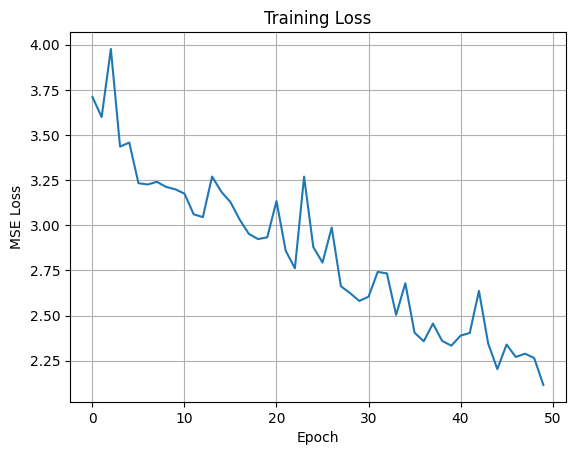

✅ 模型已保存为 simple_rass_model.pth


In [29]:
# ==================== 终极简化 LSTM 模型 ====================
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import os

# ---------- 1. 数据加载（已处理所有类型问题）----------
class RASSDataset(Dataset):
    def __init__(self, npz_path):
        data = np.load(npz_path, allow_pickle=True)
        X = data['X'].astype(np.float32)   # 强制 float32
        y = data['y'].astype(np.float32)
        # 前66维 → (N,6,11)，后4维 → (N,4)
        self.temporal = torch.from_numpy(X[:, :66].reshape(-1, 6, 11))
        self.static   = torch.from_numpy(X[:, 66:])
        self.target   = torch.from_numpy(y).view(-1, 1)
    
    def __len__(self): 
        return len(self.target)
    
    def __getitem__(self, idx):
        return self.temporal[idx], self.static[idx], self.target[idx]

def create_dataloader(npz_path, batch_size=32, shuffle=True):
    return DataLoader(RASSDataset(npz_path), batch_size=batch_size, shuffle=shuffle)

# ---------- 2. 极简模型（LSTM + 静态特征拼接）----------
class SimpleRASSModel(nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()
        # 处理时序特征：11维 → hidden_dim
        self.lstm = nn.LSTM(input_size=11, hidden_size=hidden_dim, batch_first=True)
        # 处理静态特征：4维 → hidden_dim
        self.static_fc = nn.Linear(4, hidden_dim)
        # 拼接后输出1维
        self.fc = nn.Linear(hidden_dim * 2, 1)
    
    def forward(self, temporal, static):
        # temporal: (batch, 6, 11)
        # static:   (batch, 4)
        lstm_out, (hn, cn) = self.lstm(temporal)
        last_hidden = hn[-1]                # (batch, hidden_dim)
        static_emb = self.static_fc(static) # (batch, hidden_dim)
        combined = torch.cat([last_hidden, static_emb], dim=1)  # (batch, hidden_dim*2)
        out = self.fc(combined)            # (batch, 1)
        return out

# ---------- 3. 训练（请修改路径）----------
npz_path = '/kaggle/input/nbp174/training_data_no_bp.npz'  # ⚠️ 修改成你的实际路径

# 检查路径
if not os.path.exists(npz_path):
    print("❌ 文件不存在！当前目录下文件：")
    !ls /kaggle/input/nbp174/
    raise FileNotFoundError("请将上面的 npz_path 改为正确的文件名")

# 加载数据
train_loader = create_dataloader(npz_path, batch_size=32, shuffle=True)

# 设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 模型、优化器、损失
model = SimpleRASSModel(hidden_dim=64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# 训练循环
epochs = 50
train_losses = []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for temporal, static, target in train_loader:
        temporal = temporal.to(device)
        static   = static.to(device)
        target   = target.to(device)
        
        optimizer.zero_grad()
        output = model(temporal, static)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * len(target)
    
    avg_loss = total_loss / len(train_loader.dataset)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

# 画图
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss')
plt.grid(True)
plt.show()

# 保存模型
torch.save(model.state_dict(), 'simple_rass_model.pth')
print("✅ 模型已保存为 simple_rass_model.pth")